In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/survey/df.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import joblib
from sklearn.manifold import TSNE
import umap

2025-08-14 09:46:20.377624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755164780.601922      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755164780.667621      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df=pd.read_csv('/kaggle/input/survey/df.csv')
map={'Male':0,'Female':1,'Others':0.5}
df['Gender']=df['Gender'].map(map)

In [4]:
X=df.drop(columns=['Age', 'Gender', 'Country', 'no_employees','temp_work_interfere',
                   'supervisor_temp','coworkers_temp','temp_treatment','AgeGrp','state','leave'])

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   self_employed              1243 non-null   int64  
 1   family_history             1243 non-null   int64  
 2   treatment                  1243 non-null   int64  
 3   work_interfere             1243 non-null   float64
 4   remote_work                1243 non-null   int64  
 5   tech_company               1243 non-null   int64  
 6   benefits                   1243 non-null   float64
 7   care_options               1243 non-null   float64
 8   wellness_program           1243 non-null   float64
 9   seek_help                  1243 non-null   float64
 10  anonymity                  1243 non-null   float64
 11  mental_health_consequence  1243 non-null   float64
 12  phys_health_consequence    1243 non-null   float64
 13  coworkers                  1243 non-null   float

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

[0.16055015 0.149668  ]
0.31021815045640966


Text(0.5, 1.0, 'PCA')

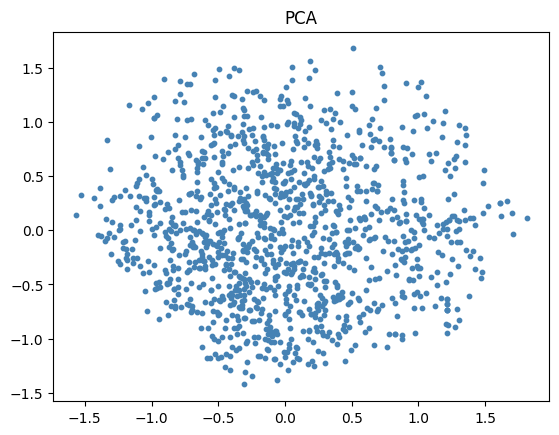

In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c='steelblue')
plt.title('PCA')

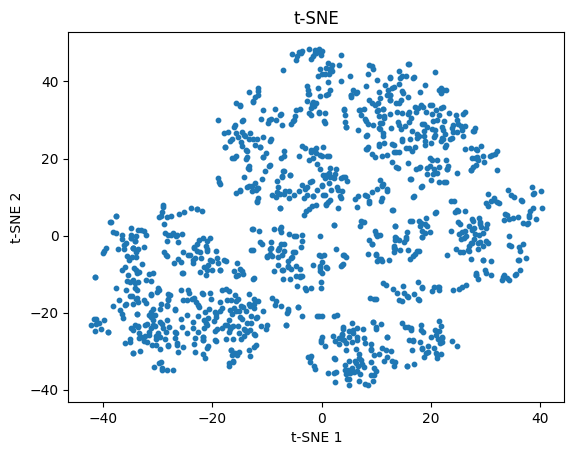

In [8]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=10)
plt.title("t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

### finding ideal number of clusters

In [9]:
X_tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])

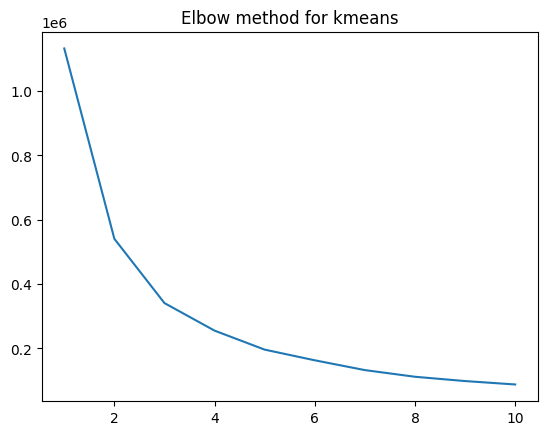

In [10]:
import warnings
warnings.filterwarnings('ignore')
inertias = []
for n in range(1, 11):
    kmeans = KMeans(
                n_clusters=n,
                init="k-means++",
                max_iter=300,
                tol=0.0001)
    kmeans.fit(X_tsne_df)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias)
plt.title("Elbow method for kmeans")
plt.show()

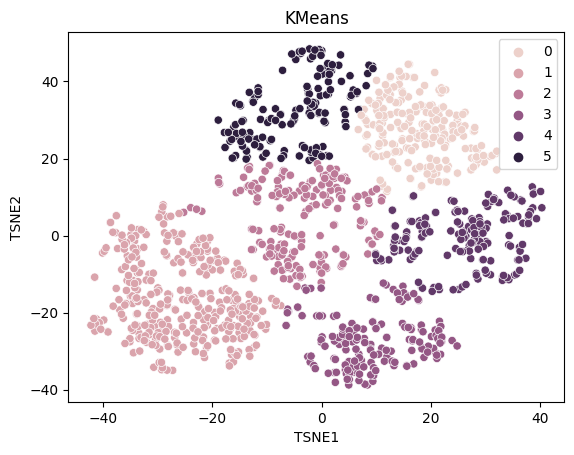

In [11]:
kmeans = KMeans(
                n_clusters=6,
                init="k-means++",
                n_init=10,
                max_iter=300,
                tol=0.0001,
                algorithm="elkan")
kmeans.fit(X_tsne_df)
fig = sns.scatterplot(x=X_tsne_df.iloc[:, 0], y=X_tsne_df.iloc[:, 1], hue=kmeans.labels_)
fig.set_title("KMeans")
plt.show()

In [12]:
from sklearn.metrics import silhouette_score
labels_knn = kmeans.labels_
print("Silhouette:", silhouette_score(X_tsne_df, labels_knn))

Silhouette: 0.43073913


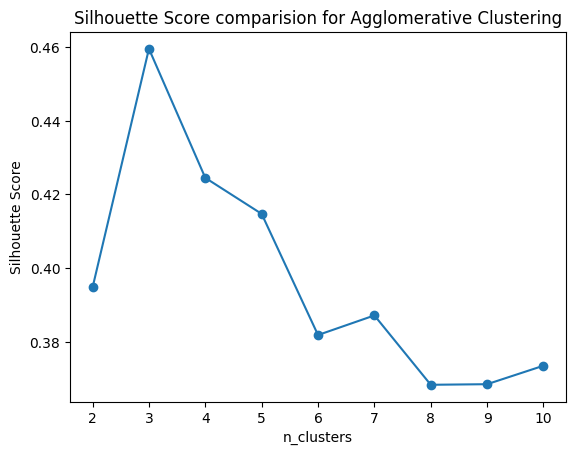

In [13]:
from sklearn.cluster import AgglomerativeClustering
sil_scores = []

for n in range(2, 11):  # must start from 2 clusters
    agg = AgglomerativeClustering(n_clusters=n, linkage='ward')
    labels = agg.fit_predict(X_tsne_df)
    score = silhouette_score(X_tsne_df, labels)
    sil_scores.append(score)

plt.plot(range(2, 11), sil_scores, marker='o')
plt.title("Silhouette Score comparision for Agglomerative Clustering")
plt.xlabel("n_clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [14]:
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agg = agg.fit_predict(X_tsne_df)
score = silhouette_score(X_tsne_df, labels_agg)
print('agglomerative silhoutte score=')
print(score)

agglomerative silhoutte score=
0.45951703


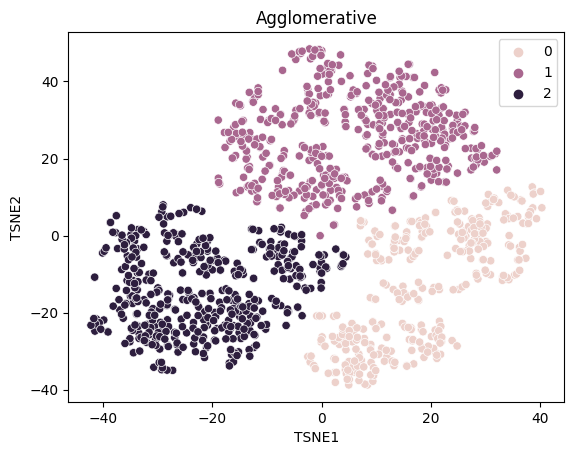

In [15]:
fig = sns.scatterplot(x=X_tsne_df.iloc[:, 0], y=X_tsne_df.iloc[:, 1], hue=labels_agg)
fig.set_title("Agglomerative")
plt.show()

### A better score is provided by Agglomerative or hierarchial clustering

In [16]:
df['labels']=pd.Series(labels_agg)

### updated dataset with labels

In [17]:
df.to_csv('/kaggle/working/cleandf.csv', index=False)

# Persona Classification

###  Cluster 0: Stable but Underinformed Allies
Mostly in their mid-30s, these individuals show moderate mental stability at work and about half have received mental health treatment. They often experience some work interference but still manage to function without severe disruption. While they’re fairly comfortable talking to coworkers and supervisors about issues, they’re not deeply aware of workplace policies — benefits, leave, and anonymity awareness are only moderate.Their limited policy knowledge means they’re not fully equipped to navigate or advocate within formal systems.

###  Cluster 1: Actively Struggling Policy-Aware Fighters
Predominantly early 30s, ****this is the most treatment-engaged group**** — nearly all have received mental health care and **many have a family history of mental health issues**. Work interference is high, yet they remain communicative with supervisors and peers. They ****display the highest awareness of workplace benefits and anonymity protections****, likely due to necessity and lived experience.Their blend of high need and high awareness makes them natural advocates, but also at risk of burnout.

###  Cluster 2: Detached but Optimistic Independents
In their early 30s on average, this group has ****no reported mental health treatment and minimal work interference****. Few have a family history of mental health challenges, and they are moderately aware of workplace benefits and policies. They are somewhat open to conversations with supervisors but less connected with coworkers. While not actively disengaged, their passive stance means they are unlikely to seek or advocate for resources unless directly impacted.